In [1]:
import pandas as pd 
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer, roc_auc_score
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.model_selection import GridSearchCV
import joblib
# import optuna
import xgboost as xgb
import catboost
import lightgbm as lgb
from skopt import BayesSearchCV

In [2]:
train_data = pd.read_csv('./train.csv')

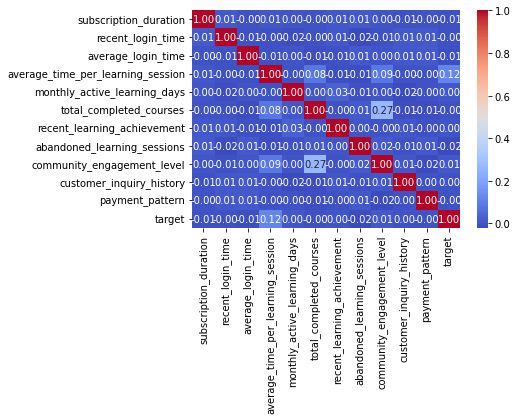

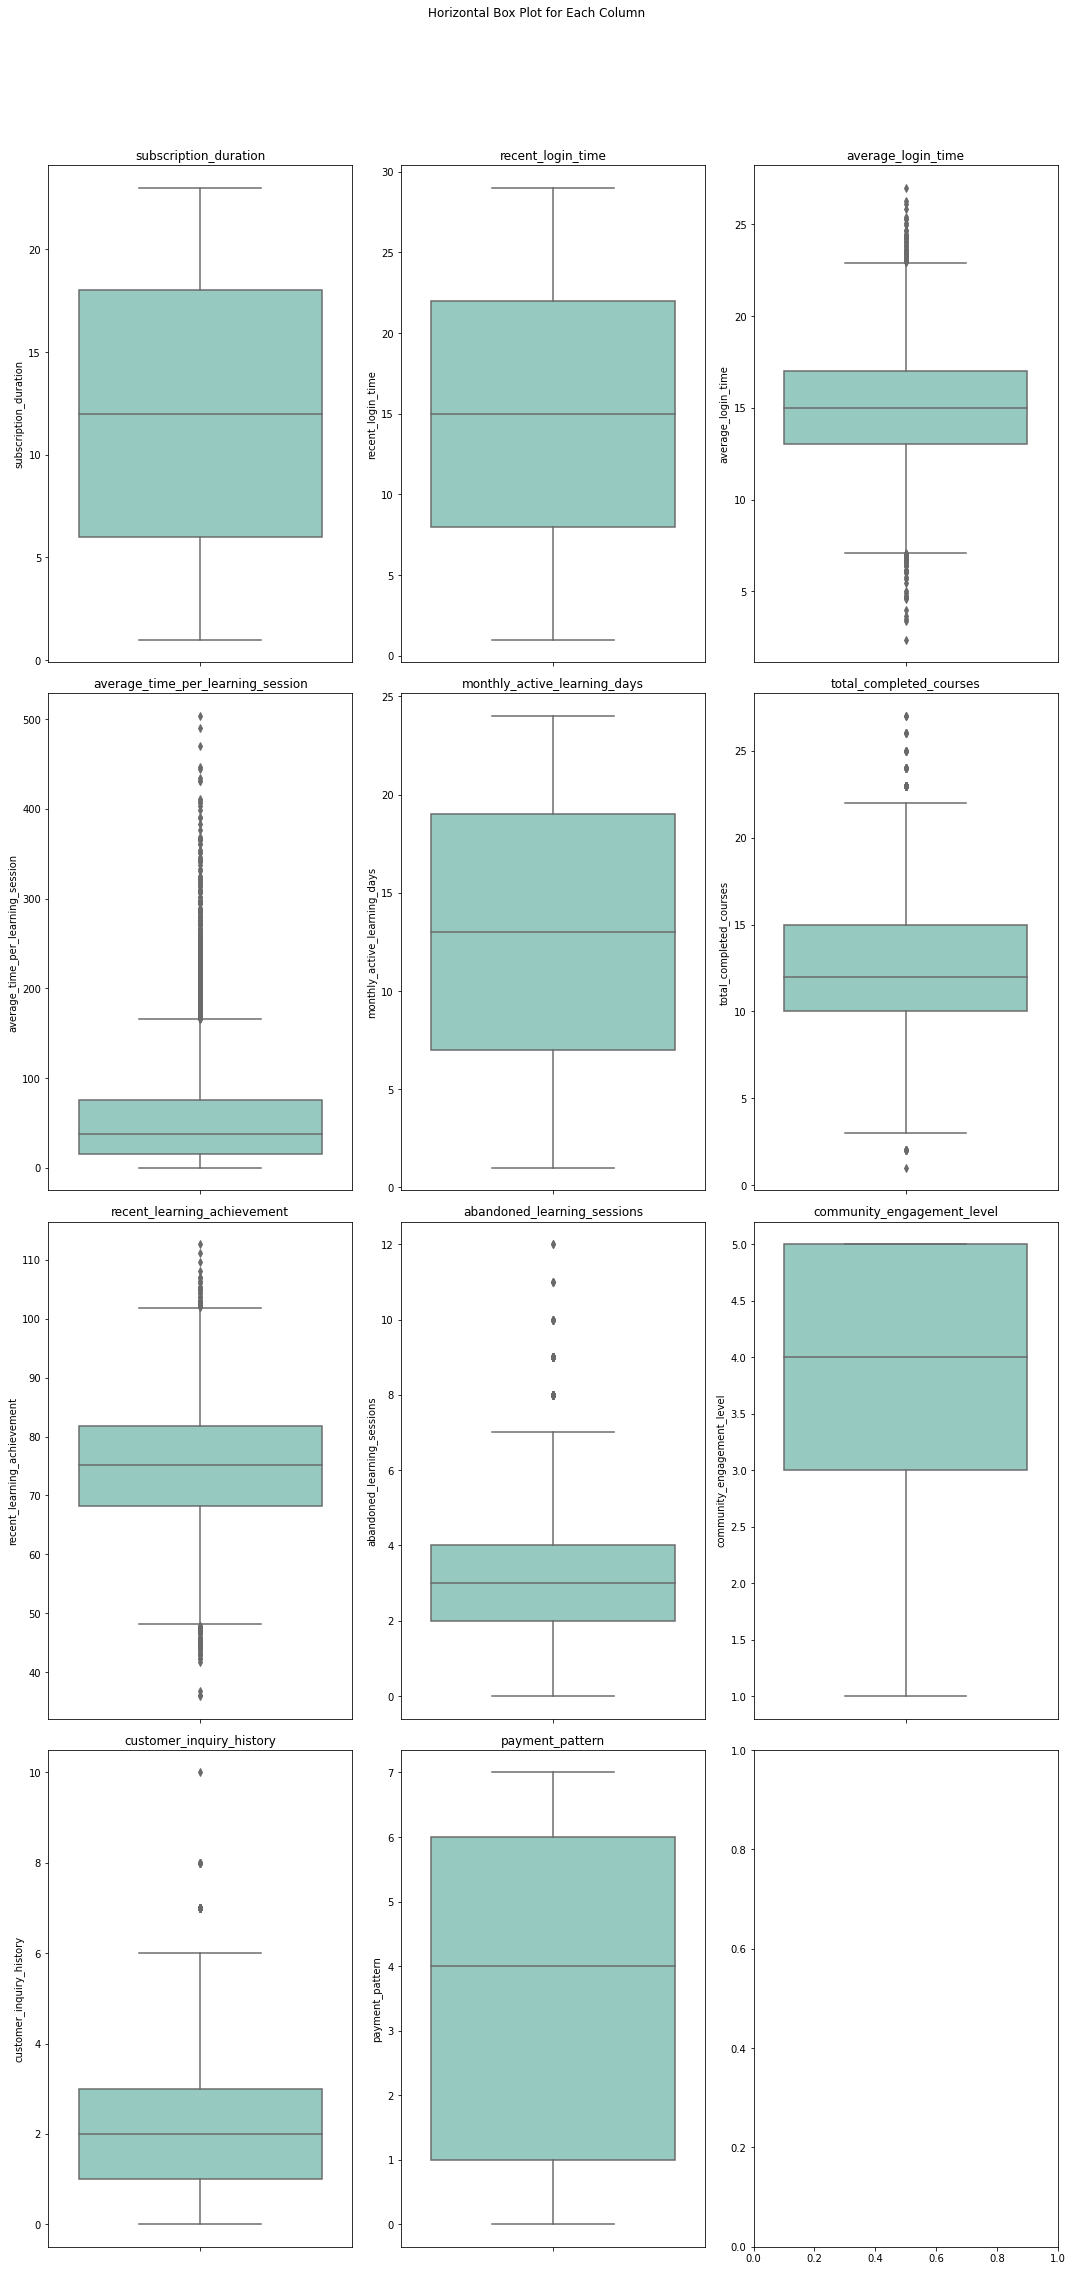

In [3]:
train_data.describe()

correlation_matrix = train_data.corr()

correlation_matrix

# 히트맵 그리기
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# 그래프 표시
plt.show()

cols = ['subscription_duration', 'recent_login_time',
       'average_login_time', 'average_time_per_learning_session',
       'monthly_active_learning_days', 'total_completed_courses',
       'recent_learning_achievement', 'abandoned_learning_sessions',
       'community_engagement_level','customer_inquiry_history', 'payment_pattern']

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예제 데이터프레임 생성

df = train_data[cols].copy()

# 개별 그림 생성
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 30))

# 각 컬럼별로 수평 box plot 그리기
for i, column in enumerate(df.columns):
    row = i // 3  # 행 인덱스 계산
    col = i % 3   # 열 인덱스 계산
    sns.boxplot(y=df[column], ax=axes[row, col], palette="Set3")  # y 축에 변수 위치
    axes[row, col].set_title(column)  # 각 그림에 컬럼명을 제목으로 추가

# 전체 그림에 제목 추가
fig.suptitle("Horizontal Box Plot for Each Column", y=1.05)

# 그림 간 간격 조정
plt.tight_layout()

# 그림 표시
plt.show()


In [4]:
df_train = train_data.copy()

In [ ]:
# box-cox 변환
df_boxcox = pd.Series(stats.boxcox(df_train['average_time_per_learning_session'])[0])
# skewness 확인
print(df_boxcox.skew())
# KDE plot 출력
sns.distplot(df_boxcox);

In [ ]:
# 클러스터 맵을 이용한 시각화
sns.clustermap(train_data.corr(), annot=True, square=True, annot_kws={'fontsize':8});
plt.show()

In [5]:
train_data
x = train_data.drop(['target','user_id'], axis = 1)
y = train_data.target
le = LabelEncoder()
df_encoded = pd.get_dummies(x, columns=['preferred_difficulty_level','subscription_type'], prefix=['preferred_difficulty_level','subscription_type'])
df_labeled = x.copy()
df_labeled['preferred_difficulty_level'] = le.fit_transform(x['preferred_difficulty_level'])
df_labeled['subscription_type'] = le.fit_transform(x['subscription_type'])

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_encoded)
labels = kmeans.labels_

In [ ]:
df_encoded.user_seg.value_counts()

In [7]:
df_encoded['user_seg'] = labels
df_labeled['user_seg'] = labels

In [8]:
X = df_encoded.copy()
# X = df_labeled.copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  stratify = y)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


# 클러스터 개수에 따른 변동성 저장
inertia_values = []

# 1부터 10까지의 클러스터 개수에 대해 K-Means 실행
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_encoded)
    inertia_values.append(kmeans.inertia_)

# Elbow 그래프 그리기
plt.plot(range(1, 21), inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


In [ ]:
print(len(df_encoded), len(X))
print(len(df_encoded.columns), len(X.columns))

In [ ]:
# df_encoded.user_seg.value_counts()
# box-cox 변환
df_encoded['average_time_per_learning_session'] = pd.Series(stats.boxcox(df_encoded['average_time_per_learning_session'])[0])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score



# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
# X_train, X_test, y_train, y_test = train_test_split(df_labeled, y, test_size=0.2, random_state=42)

# 스케일러
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 다양한 분류 모델 초기화
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

# 모델 평가
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name}:")
    print(f"Cross-validated Accuracy: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

    # 모델 학습 및 평가
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print()


In [ ]:
### user_seg == 4일때

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score



# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42, stratify = y)
# X_train, X_test, y_train, y_test = train_test_split(df_labeled, y, test_size=0.2, random_state=42)

# 스케일러
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 다양한 분류 모델 초기화
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

# 모델 평가
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='f1')
    print(f"{model_name}:")
    print(f"Cross-validated Accuracy: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

    # 모델 학습 및 평가
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print()


In [ ]:
### user_seg == 5일때

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score



# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(df_labeled, y, test_size=0.2, random_state=42)

# 스케일러
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 다양한 분류 모델 초기화
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier()
}

proba_df = pd.DataFrame()

# 모델 평가
for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name}:")
    print(f"Cross-validated Accuracy: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

    # 모델 학습 및 평가
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test)
    proba_df[model_name] = proba[:, 1]
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print()
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-----------------------------------------------------------------------------------------------")

proba_df['Target'] = y_test.reset_index(drop=True)


In [ ]:
proba_df

### catboosting 모델

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# CatBoost 분류 모델을 초기화합니다.
model = CatBoostClassifier(iterations=1000,
                           metric_period = 100,
                           early_stopping_rounds = 100,
                           # eval_metric = 'Accuracy',
                           grow_policy = 'Lossguide',
                           learning_rate= 0.05, 
                           depth=16,
                           l2_leaf_reg = 32, 
                           loss_function='Logloss',
                           random_seed=42)

# 모델을 훈련합니다.
model.fit(X_train, y_train, cat_features=["user_seg"])

# 테스트 세트에서 예측을 수행합니다.
y_pred = model.predict(X_test)

In [ ]:
# 정확도와 분류 보고서를 출력합니다.
accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"f1_score: {test_f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
test_data = pd.read_csv('./test.csv')
test_data = test_data.drop(['user_id'], axis = 1)
test_data = pd.get_dummies(test_data, columns=['preferred_difficulty_level','subscription_type'], prefix=['preferred_difficulty_level','subscription_type'])
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(test_data)
labels = kmeans.labels_
test_data['user_seg'] = labels
test_data['average_time_per_learning_session'] = pd.Series(stats.boxcox(test_data['average_time_per_learning_session'])[0])
actual_test = model.predict(test_data)
submit = pd.read_csv("./sample_submission.csv")
submit['target'] = actual_test

In [ ]:
test_data.user_seg.value_counts()

In [ ]:
for idx in range(len(test_data.user_seg)):
    if test_data.user_seg[idx] == 1:
        test_data.user_seg[idx] = 2
    elif test_data.user_seg[idx] == 2:
        test_data.user_seg[idx] = 0
    elif test_data.user_seg[idx] == 0:
        test_data.user_seg[idx] = 1

In [ ]:
actual_test

In [ ]:
submit = pd.read_csv("./sample_submission.csv")
submit['target'] = actual_test

In [ ]:
submit

In [ ]:
submit.to_csv(f'submit_xgboost_sample.csv', index = False)

In [ ]:
os.getcwd()

In [ ]:
pip install xgboost

In [ ]:
import xgboost as xgb

In [ ]:
y_train.value_counts()
print(3043/4957)

In [ ]:
# XGBoost 분류 모델을 초기화합니다.
model = xgb.XGBClassifier(objective="binary:logistic",
                          n_estimators = 512, 
                          learning_rate = 0.005, 
                          random_state=42, 
                          scale_pos_weight = 0.61,
                          gamma= 1, 
                          subsample= 0.5, 
                          eval_metric = "error",
                          colsample_bytree=0.5,
                          max_depth=10)

# 모델을 훈련합니다.
model.fit(X_train, y_train)

# 테스트 세트에서 예측을 수행합니다.
y_pred = model.predict(X_test)

# 정확도와 분류 보고서를 출력합니다.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [ ]:
actual_test = model.predict(test_data)

In [39]:
params_dics = {"Trial_5" : {'iterations': 3494, 'depth': 15, 'learning_rate': 0.004109972438600079, 'random_strength': 3.6609432304933944e-06, 'bagging_temperature': 1.6438322417395697, 'border_count': 184, 'l2_leaf_reg': 0.010704003551279468, 'scale_pos_weight': 0.28228897308770146},
"Trial_40" : {'iterations': 3171, 'depth': 16, 'learning_rate': 0.021006034924643667, 'random_strength': 0.861071947753773, 'bagging_temperature': 0.27718660652113153, 'border_count': 128, 'l2_leaf_reg': 1.3440278876473406, 'scale_pos_weight': 0.306323455051013},
"Trial_39" : {'iterations': 1998, 'depth': 7, 'learning_rate': 0.004062970923392713, 'random_strength': 0.15974934345422212, 'bagging_temperature': 1.6087275170293391, 'border_count': 165, 'l2_leaf_reg': 29.396503066868984, 'scale_pos_weight': 0.16832739314314094},
"Trial_0" : {'iterations': 1460, 'depth': 8, 'learning_rate': 0.005308129125524093, 'random_strength': 2.861991298919936, 'bagging_temperature': 0.1876492719160405, 'border_count': 242, 'l2_leaf_reg': 0.45408974235631977, 'scale_pos_weight': 0.5154293315741206},
"Trial_11" : {'iterations': 1881, 'depth': 4, 'learning_rate': 0.07968940332210986, 'random_strength': 0.028676034609246667, 'bagging_temperature': 7.28947822370342, 'border_count': 48, 'l2_leaf_reg': 26.195349301167234, 'scale_pos_weight': 0.10861868585937294},
"Trial_15" : {'iterations': 1785, 'depth': 9, 'learning_rate': 0.006662607107187308, 'random_strength': 0.005697091070009178, 'bagging_temperature': 0.26229403970117277, 'border_count': 144, 'l2_leaf_reg': 3.3692930363732927, 'scale_pos_weight': 0.11535350565296527},
"Trial_21" : {'iterations': 1485, 'depth': 4, 'learning_rate': 0.015115232252570774, 'random_strength': 1.115079119989872, 'bagging_temperature': 0.10039312671312262, 'border_count': 99, 'l2_leaf_reg': 8.552664263051177, 'scale_pos_weight': 0.10401079900509261},
"Trial_22" : {'iterations': 1494, 'depth': 7, 'learning_rate': 0.011740810399874185, 'random_strength': 9.307391066151396, 'bagging_temperature': 0.10963981723583587, 'border_count': 105, 'l2_leaf_reg': 6.033032918165549, 'scale_pos_weight': 0.24458910545781826},
"Trial_23" :{'iterations': 2187, 'depth': 6, 'learning_rate': 0.012535429229356444, 'random_strength': 9.084619092847042, 'bagging_temperature': 0.10614226786021125, 'border_count': 109, 'l2_leaf_reg': 5.134329147999177, 'scale_pos_weight': 0.20988269189378322},
"Trial_24" : {'iterations': 2173, 'depth': 6, 'learning_rate': 0.010443511476221832, 'random_strength': 8.284888179985684, 'bagging_temperature': 0.41504411924109436, 'border_count': 116, 'l2_leaf_reg': 8.392762396594591, 'scale_pos_weight': 0.28958238222706406},
"Trial_25" : {'iterations': 2267, 'depth': 6, 'learning_rate': 0.009579508942741535, 'random_strength': 0.1749099766198652, 'bagging_temperature': 0.40675708453387055, 'border_count': 123, 'l2_leaf_reg': 10.754320674403367, 'scale_pos_weight': 0.17190065967092144},
"Trial_27" : {'iterations': 2246, 'depth': 5, 'learning_rate': 0.009098161454858996, 'random_strength': 0.4160332831567079, 'bagging_temperature': 0.4517428581884058, 'border_count': 77, 'l2_leaf_reg': 10.953520950862481, 'scale_pos_weight': 0.1894054086361976} }

In [ ]:
for k, v in params_dics.items():
    fix = {'metric_period' : 100,
        'early_stopping_rounds' : 100,
        'bootstrap_type' : "Bayesian",
        'grow_policy' : 'Depthwise'}
    v.update(fix)
    # print(v)
    model = catboost.CatBoostClassifier(**v, verbose=1)
    stratified_cv = StratifiedKFold(n_splits=3, shuffle=True)
    f1_scorer = make_scorer(f1_score, average='macro')
    auc_scorer = make_scorer(roc_auc_score)
    scores = cross_val_score(model, X_train, y_train, cv=stratified_cv, scoring=f1_scorer)
    print(f"{k}:")
    print(f"Cross-validated F1: {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")

In [41]:
fix = {'metric_period' : 100,
        'early_stopping_rounds' : 100,
        'bootstrap_type' : "Bayesian",
        'grow_policy' : 'Depthwise'}

params_dics["Trial_40"].update(fix)

T40_model = catboost.CatBoostClassifier(**params_dics["Trial_40"], verbose=1)
T40_model.fit(X_train, y_train)

0:	learn: 0.6825416	total: 117ms	remaining: 6m 10s
100:	learn: 0.1739992	total: 13s	remaining: 6m 36s
200:	learn: 0.0711088	total: 26.4s	remaining: 6m 30s
300:	learn: 0.0349374	total: 41s	remaining: 6m 30s
400:	learn: 0.0203735	total: 57.1s	remaining: 6m 34s
500:	learn: 0.0130116	total: 1m 13s	remaining: 6m 33s
600:	learn: 0.0100040	total: 1m 26s	remaining: 6m 9s
700:	learn: 0.0083984	total: 1m 39s	remaining: 5m 50s
800:	learn: 0.0074887	total: 1m 52s	remaining: 5m 33s
900:	learn: 0.0068378	total: 2m 5s	remaining: 5m 16s
1000:	learn: 0.0061425	total: 2m 19s	remaining: 5m 2s
1100:	learn: 0.0055223	total: 2m 32s	remaining: 4m 47s
1200:	learn: 0.0050698	total: 2m 41s	remaining: 4m 24s
1300:	learn: 0.0046489	total: 2m 47s	remaining: 4m
1400:	learn: 0.0043134	total: 2m 52s	remaining: 3m 38s
1500:	learn: 0.0040305	total: 2m 58s	remaining: 3m 18s
1600:	learn: 0.0038022	total: 3m 3s	remaining: 2m 59s
1700:	learn: 0.0036026	total: 3m 9s	remaining: 2m 43s
1800:	learn: 0.0034157	total: 3m 14s	rem

In [ ]:
T0_model = catboost.CatBoostClassifier(**params_dics["Trial_0"], verbose=1)
T0_model.fit(X_train, y_train)

In [ ]:
test40 = T40_model.predict(X_test)
test0 = T0_model.predict(X_test)
report40 = classification_report(y_test, test40)
report0 = classification_report(y_test, test0)

print("\nClassification Report:\n", report40)
print("\nClassification Report:\n", report0)

In [63]:
def summit_data(model, name):
    test_data = pd.read_csv('./test.csv')
    test_data = test_data.drop(['user_id'], axis = 1)
    test_data = pd.get_dummies(test_data, columns=['preferred_difficulty_level','subscription_type'], prefix=['preferred_difficulty_level','subscription_type'])
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(test_data)
    labels = kmeans.labels_
    test_data['user_seg'] = labels
    test_data['average_time_per_learning_session'] = pd.Series(stats.boxcox(test_data['average_time_per_learning_session'])[0])
    actual_test = model.predict(test_data)
    submit = pd.read_csv("./sample_submission.csv")
    submit['target'] = actual_test
    return submit.to_csv(f"{name}.csv",index= False)

In [44]:
def test(model):
    test = model.predict(X_test)
    report = classification_report(y_test, test)
    
    return print(report)

def test_proba(model):
    test = model.predict_proba(X_test)
    
    return test
    

In [ ]:
T40_model

In [ ]:
summit_data(T40_model,"T40_model")
summit_data(T0_model,"T0_model")

In [34]:
# 저장된 모델 파일 로드
T1_model = joblib.load('./0_model.joblib')
T2_model = joblib.load('./1_model.joblib')
# T3_model = joblib.load('./2_model.joblib')


C:\Users\DIQUEST\anaconda3\envs\diquest\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier()

# 튜닝할 하이퍼파라미터 그리드 정의
param_grid = {
    'num_leaves': [128, 144, 196, 256, 288, 300],
    'n_estimators': [150, 200, 250, 300],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'verbose': [-2],
    'force_col_wise' : [True, False]
}

# GridSearchCV를 사용하여 그리드 서치 수행
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring=f1_scorer, cv=3)
grid_result = grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_result.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
lgb_model = lgb.LGBMClassifier(**grid_result.best_params_)
lgb_model.fit(X_train,y_train)
test(lgb_model)

In [22]:
fixed_params = {
    'max_depth': 9,
    'verbose': -1,
    'force_col_wise' : True,
    'objective': 'binary',
    'metric': 'auc',
}

In [31]:
from skopt import BayesSearchCV

# LightGBM 모델 정의
lgb_model = lgb.LGBMClassifier()

# 튜닝할 하이퍼파라미터 탐색 공간 정의
param_space = {
    'n_estimators': (350, 500),
    'num_leaves': [349],
    'learning_rate': (0.05, 0.1, 'log-uniform'),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'max_depth': [9],
    'verbose': [-1],
    'force_col_wise' : [True],
    'objective': ['binary'],
    'metric': ['auc'],
}


stratified_cv = StratifiedKFold(n_splits=5, shuffle=True)
f1_scorer = make_scorer(f1_score, average='macro')
# BayesSearchCV를 사용하여 베이지안 최적화 수행
bayes_search = BayesSearchCV(estimator=lgb_model, 
                             search_spaces=param_space, 
                             scoring=f1_scorer, 
                             # fit_params=fixed_params,
                             cv=stratified_cv, 
                             return_train_score = True,
                             n_iter = 100,
                             n_jobs=None)
bayes_result = bayes_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = bayes_result.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: OrderedDict([('colsample_bytree', 0.9994745184144532), ('force_col_wise', True), ('learning_rate', 0.07449543379654792), ('max_depth', 9), ('metric', 'auc'), ('n_estimators', 450), ('num_leaves', 349), ('objective', 'binary'), ('subsample', 0.7457403067248004), ('verbose', -1)])


In [28]:
lgb_model = lgb.LGBMClassifier(**best_params)
lgb_model.fit(X_train,y_train)
test(lgb_model)

              precision    recall  f1-score   support

           0       0.40      0.26      0.32       760
           1       0.63      0.75      0.68      1240

    accuracy                           0.57      2000
   macro avg       0.51      0.51      0.50      2000
weighted avg       0.54      0.57      0.54      2000



In [32]:
lgb_model = lgb.LGBMClassifier(**best_params)
lgb_model.fit(X_train,y_train)
test(lgb_model)

              precision    recall  f1-score   support

           0       0.42      0.28      0.34       760
           1       0.63      0.76      0.69      1240

    accuracy                           0.58      2000
   macro avg       0.53      0.52      0.51      2000
weighted avg       0.55      0.58      0.56      2000



In [42]:
xgb_model = T1_model
cgb_model = T40_model

In [37]:
lgb_model

LGBMClassifier(colsample_bytree=0.9994745184144532, force_col_wise=True,
               learning_rate=0.07449543379654792, max_depth=9, metric='auc',
               n_estimators=450, num_leaves=349, objective='binary',
               subsample=0.7457403067248004, verbose=-1)

In [54]:
lgb_proba = test_proba(lgb_model)
xgb_proba = test_proba(xgb_model)
cgb_proba = test_proba(cgb_model)

              precision    recall  f1-score   support

           0       0.42      0.28      0.34       760
           1       0.63      0.76      0.69      1240

    accuracy                           0.58      2000
   macro avg       0.53      0.52      0.51      2000
weighted avg       0.55      0.58      0.56      2000



In [47]:
from sklearn.ensemble import VotingClassifier

In [53]:
# VotingClassifier 정의 (weights 파라미터 사용)
voting_clf = VotingClassifier(estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cgb', cgb_model)], 
                              voting='soft',
                              weights=[2, 1, 1])
# Soft Voting 분류기 학습
voting_clf.fit(X_train, y_train)

# Soft Voting 분류기의 정확도 출력
test(voting_clf)

0:	learn: 0.6825416	total: 143ms	remaining: 7m 34s
100:	learn: 0.1739992	total: 14.6s	remaining: 7m 23s
200:	learn: 0.0711088	total: 29.1s	remaining: 7m 10s
300:	learn: 0.0349374	total: 45.9s	remaining: 7m 18s
400:	learn: 0.0203735	total: 1m 4s	remaining: 7m 27s
500:	learn: 0.0130116	total: 1m 23s	remaining: 7m 25s
600:	learn: 0.0100040	total: 1m 37s	remaining: 6m 58s
700:	learn: 0.0083984	total: 1m 52s	remaining: 6m 35s
800:	learn: 0.0074887	total: 2m 6s	remaining: 6m 15s
900:	learn: 0.0068378	total: 2m 20s	remaining: 5m 54s
1000:	learn: 0.0061425	total: 2m 35s	remaining: 5m 36s
1100:	learn: 0.0055223	total: 2m 50s	remaining: 5m 20s
1200:	learn: 0.0050698	total: 2m 59s	remaining: 4m 55s
1300:	learn: 0.0046489	total: 3m 5s	remaining: 4m 27s
1400:	learn: 0.0043134	total: 3m 11s	remaining: 4m 2s
1500:	learn: 0.0040305	total: 3m 17s	remaining: 3m 40s
1600:	learn: 0.0038022	total: 3m 24s	remaining: 3m 20s
1700:	learn: 0.0036026	total: 3m 29s	remaining: 3m 1s
1800:	learn: 0.0034157	total: 3

In [64]:
summit_data(voting_clf, "voting_clf")

In [92]:
def soft_voting(w1,w2,w3,m1,m2,m3):
    # Soft Voting을 위해 각 모델의 예측 확률에 가중치를 곱하고 평균 계산
    weight_model1 = w1  # 모델1에 대한 가중치
    weight_model2 = w2  # 모델2에 대한 가중치
    weight_model3 = w3
    weighted_avg_proba = ( (weight_model1 * m1) + (weight_model2 * m2) + (weight_model3 * m3) ) / (weight_model1 + weight_model2 + weight_model3)

    # VotingClassifier를 사용하여 예측
    y_pred_voting = np.argmax(weighted_avg_proba, axis=1)

    # VotingClassifier의 정확도 출력
    # return roc_auc_score(y_test, y_pred_voting)
    return y_pred_voting

In [89]:
def find_combinations(total_sum, num_elements):
    # 가능한 모든 조합을 찾는 함수
    def find_combinations_recursive(current_sum, remaining_elements, current_combination):
        # 종료 조건: 3개의 수를 모두 선택한 경우
        if len(current_combination) == num_elements:
            if current_sum == total_sum:
                combinations.append(np.array(current_combination))
            return

        # 재귀적으로 가능한 모든 조합을 찾음
        for element in remaining_elements:
            new_sum = current_sum + element
            new_combination = current_combination + [element]
            new_remaining = [e for e in remaining_elements if e <= total_sum - new_sum]
            find_combinations_recursive(new_sum, new_remaining, new_combination)

    # 초기 설정 및 함수 호출
    combinations = []
    elements = list(range(1, 1000))  # 1부터 99까지의 숫자를 사용
    find_combinations_recursive(0, elements, [])

    return combinations

# 총합이 100이 되는 3개의 숫자 조합을 찾음
total_sum = 1000
num_elements = 3
result = find_combinations(total_sum, num_elements)

In [90]:
len(result)

4851

In [130]:
max_roc = 0
max_f1 = 0
max_acc = 0
for idx, case in enumerate(np.array(result)):
    
    case = case*0.001
    
    w1 = case[0]
    w2 = case[1]
    w3 = case[2]
    
    y_pred_voting = soft_voting(w1,w2,w3,lgb_proba,xgb_proba,cgb_proba)
    tmp_roc = roc_auc_score(y_test, y_pred_voting)
    tmp_f1 = f1_score(y_test, y_pred_voting, average = "macro")
    tmp_acc = accuracy_score(y_test, y_pred_voting)
    if max_roc < tmp_roc :
        max_roc = tmp_roc
        max_case_roc = idx
    if max_f1 < tmp_f1 :
        max_f1 = tmp_f1
        max_case_f1 = idx
    if max_acc < tmp_acc :
        max_acc = tmp_acc
        max_case_acc = idx
    

    

In [109]:
print(max_case_acc)
print(max_case_f1)
print(max_case_roc)

928
4850
1016


In [115]:
result[928]

array([10, 83,  7])

In [101]:
test_data = pd.read_csv('./test.csv')
test_data = test_data.drop(['user_id'], axis = 1)
test_data = pd.get_dummies(test_data, columns=['preferred_difficulty_level','subscription_type'], prefix=['preferred_difficulty_level','subscription_type'])
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(test_data)
labels = kmeans.labels_
test_data['user_seg'] = labels
test_data['average_time_per_learning_session'] = pd.Series(stats.boxcox(test_data['average_time_per_learning_session'])[0])


In [97]:
def summit_data_proba(result):
    test_data = pd.read_csv('./test.csv')
    test_data = test_data.drop(['user_id'], axis = 1)
    test_data = pd.get_dummies(test_data, columns=['preferred_difficulty_level','subscription_type'], prefix=['preferred_difficulty_level','subscription_type'])
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(test_data)
    labels = kmeans.labels_
    test_data['user_seg'] = labels
    test_data['average_time_per_learning_session'] = pd.Series(stats.boxcox(test_data['average_time_per_learning_session'])[0])
    submit = pd.read_csv("./sample_submission.csv")
    submit['target'] = result
    return submit.to_csv(f"{result}.csv",index= False)

In [117]:
y_pred_4850 = soft_voting_proba(98,1,1,lgb_proba,xgb_proba,cgb_proba, test_data)
y_pred_928 = soft_voting_proba(10,83,7,lgb_proba,xgb_proba,cgb_proba, test_data)

AttributeError: 'numpy.ndarray' object has no attribute 'predict_proba'

In [102]:
def soft_voting_proba(w1,w2,w3,m1,m2,m3, test_data):
    # Soft Voting을 위해 각 모델의 예측 확률에 가중치를 곱하고 평균 계산
    weight_model1 = w1  # 모델1에 대한 가중치
    weight_model2 = w2  # 모델2에 대한 가중치
    weight_model3 = w3
    m1_proba = m1.predict_proba(test_data)
    m2_proba = m2.predict_proba(test_data)
    m3_proba = m3.predict_proba(test_data)
    weighted_avg_proba = ( (weight_model1 * m1_proba) + (weight_model2 * m2_proba) + (weight_model3 * m3_proba) ) / (weight_model1 + weight_model2 + weight_model3)

    # VotingClassifier를 사용하여 예측
    y_pred_voting = np.argmax(weighted_avg_proba, axis=1)

    # VotingClassifier의 정확도 출력
    # return roc_auc_score(y_test, y_pred_voting)
    return y_pred_voting

In [118]:
# summit_pred_voting = soft_voting_proba(11,82,7,lgb_model,xgb_model,cgb_model, test_data)

y_pred_4850 = soft_voting_proba(98,1,1,lgb_model,xgb_model,cgb_model, test_data)
y_pred_928 = soft_voting_proba(10,83,7,lgb_model,xgb_model,cgb_model, test_data)

In [106]:
summit_pred_voting

array([1, 1, 0, ..., 0, 1, 0], dtype=int64)

In [119]:
submit = pd.read_csv("./sample_submission.csv")
submit['target'] = y_pred_4850
submit.to_csv(f"y_pred_4850.csv",index= False)

In [120]:
submit = pd.read_csv("./sample_submission.csv")
submit['target'] = y_pred_928
submit.to_csv(f"y_pred_928.csv",index= False)

In [126]:
from itertools import product
from tqdm import tqdm

def find_combinations(total_sum, num_elements):
    # 가능한 모든 조합을 찾는 함수
    candidates = range(1, 1000)  # 1부터 9까지의 숫자를 사용

    # 중복을 허용하는 num_elements개의 숫자 조합을 찾음
    valid_combinations = []
    for comb in tqdm(product(candidates, repeat=num_elements), total=len(candidates) ** num_elements, desc="Finding Combinations"):
        if sum(comb) == total_sum:
            valid_combinations.append(comb)

    return valid_combinations

# 총합이 100이 되는 3개의 숫자 조합을 찾음
total_sum = 1000
num_elements = 3
result = find_combinations(total_sum, num_elements)

# # 결과 출력
# for i, combination in enumerate(result, start=1):
#     print(f"Case {i}: {combination}")



Finding Combinations: 100%|█████████████████████████████████████████| 997002999/997002999 [04:38<00:00, 3584478.14it/s]


In [128]:
result[0]

(1, 1, 998)